#### CNN model for Portfolio Optimization using PCA as the inputs

The purpose of this hybrid PCA–autoencoder–CNN approach is to leverage the strengths of both linear and non-linear dimensionality reduction techniques in order to extract the most informative features from high-dimensional financial data before portfolio optimization. First, Principal Component Analysis (PCA) is used to reduce noise and compress the data by capturing the most significant linear relationships, which helps mitigate the curse of dimensionality and improves interpretability. Next, an autoencoder further refines this representation by learning non-linear patterns and hierarchical features that PCA cannot capture, resulting in more robust and informative latent factors. These compressed features are then used as input to a convolutional neural network (CNN), which learns to construct optimal portfolio weights based on the extracted factors. This integrated pipeline aims to improve model performance, reduce overfitting, and enhance the ability to uncover complex relationships in financial markets, ultimately supporting more effective and adaptive portfolio optimization.

Related
What is the main goal of using autoencoders in data compression and noise reduction
How do autoencoders help in capturing essential features from complex data
Why are regularization techniques like contractive autoencoders important for model robustness
In what ways do denoising autoencoders improve data quality for machine learning tasks
How does understanding the purpose of autoencoders enhance their application in various fields


### Running Code

### Academic Explanation

In [22]:
from graphviz import Digraph

def plot_cnn_pca_architecture_high_res():
    dot = Digraph('CNN_PCA_Portfolio_Architecture_HighRes', comment='CNN-PCA Portfolio Optimization Architecture', format='svg') # Change format here
    dot.attr(rankdir='TB', size='8,10') # Adjust size as needed, though for SVG it scales

    # Set global node attributes for consistent styling
    dot.attr('node', shape='box', style='rounded,filled', fontname='Helvetica', fontsize='10') # Use a common font

    # Input Layer
    dot.node('input', '''Input Layer
[batch, lookback, 8 assets × 8 features]
(returns, RSI, MACD, etc.)''', fillcolor='#e6f2ff') # Light blue

    # PCA Layer (now mandatory in this pipeline, so removing 'optional')
    dot.node('pca', '''PCA Layer
[batch, lookback, 5_components]
(Dimensionality Reduction)''', fillcolor='#cce6ff') # Slightly darker blue

    # Placeholder for input to Conv1D (if PCA output is 2D, CNN needs 3D: batch, features, sequence_length)
    # The image you provided has an "Unsqueeze" which implies adding a dimension for 2D Conv.
    # For a 1D CNN, your data (batch, lookback, n_components) needs to be (batch, n_components, lookback)
    # So, a simple Permute/Transpose or just note the shape change.
    # Let's adjust to be clearer for a 1D CNN based on your code:
    dot.node('conv_input_prep', '''Data Reshape/Permute
[batch, n_components, lookback]''', fillcolor='#e6f2ff')

    # Conv1D Layer (as per your code, you use 1D CNN)
    dot.node('conv1d_1', '''Conv1D Layer 1
filters=64, kernel_size=3
Output: [batch, 64, (lookback-2)]''', fillcolor='#99ccff') # Medium blue

    dot.node('relu1', '''ReLU Activation''', fillcolor='#b3d1ff') # Non-linearity

    dot.node('conv1d_2', '''Conv1D Layer 2
filters=32, kernel_size=3
Output: [batch, 32, (lookback-4)]''', fillcolor='#66a3ff') # Darker blue

    dot.node('relu2', '''ReLU Activation''', fillcolor='#b3d1ff')

    # Flatten Layer
    dot.node('flatten', '''Flatten Layer
Output: [batch, flattened_size]''', fillcolor='#e6f2ff')

    # Dropout Layer (optional, but good to include if in code)
    dot.node('dropout', '''Dropout Layer''', fillcolor='#e6f2ff')


    # Fully Connected Layer 1 (Hidden Layer)
    dot.node('fc1_hidden', '''Fully Connected Layer 1
(Hidden: 64 neurons)''', fillcolor='#3366ff') # Dark blue

    dot.node('relu3', '''ReLU Activation''', fillcolor='#b3d1ff')

    # Output Layer for Sharpe Ratio
    dot.node('sharpe_output', '''Output: Sharpe Ratio
[batch, 1] (Linear Activation)''', fillcolor='#b2e6b2') # Greenish for output

    # Output Layer for Portfolio Weights
    dot.node('weights_output', '''Output: Portfolio Weights
[batch, N assets] (Softmax Activation)''', fillcolor='#85e085') # Darker green for output

    # Edges: Define the flow
    dot.edge('input', 'pca', label='Raw Features')
    dot.edge('pca', 'conv_input_prep', label='Principal Components')
    dot.edge('conv_input_prep', 'conv1d_1')
    dot.edge('conv1d_1', 'relu1')
    dot.edge('relu1', 'conv1d_2')
    dot.edge('conv1d_2', 'relu2')
    dot.edge('relu2', 'flatten')
    dot.edge('flatten', 'dropout')
    dot.edge('dropout', 'fc1_hidden')
    dot.edge('fc1_hidden', 'relu3') # Connect to ReLU after FC1

    # Split for dual outputs
    dot.edge('relu3', 'sharpe_output', label='Regression Head')
    dot.edge('relu3', 'weights_output', label='Classification Head') # Softmax implies classification-like output

    return dot

# Generate and render the high-resolution graph
cnn_pca_arch_high_res = plot_cnn_pca_architecture_high_res()
cnn_pca_arch_high_res.render('cnn_pca_portfolio_architecture_high_res', view=True)


'cnn_pca_portfolio_architecture_high_res.svg'

# Methodology: Convolutional Neural Network (CNN) Using Principal Component Analysis (PCA) for Portfolio Optimization

This study develops a hybrid machine learning framework that integrates **Principal Component Analysis (PCA)** with a **1-Dimensional Convolutional Neural Network (1D CNN)** to construct dynamic portfolio allocations. The approach addresses the challenges of high-dimensional financial data, multicollinearity among features, and non-stationary market dynamics, aiming to improve risk-adjusted returns and portfolio robustness.

## 1. Data Collection and Feature Engineering

### 1.1 Asset Universe and Data Sources

The asset universe comprises eight Exchange-Traded Funds (ETFs) representing diverse asset classes:

- **ARKK** (Innovative Technology Equities)
- **AGG** (Aggregate Bond Market)
- **GLD** (Gold)
- **HYG** (High-Yield Corporate Bonds)
- **SPY** (S&P 500 Index)
- **USO** (Oil)
- **VNQ** (Real Estate Investment Trusts)
- **VXUS** (International Equities)

These ETFs collectively provide broad exposure to equity, fixed income, commodity, and real estate markets, enabling diversified portfolio construction.

### 1.2 Financial and Macroeconomic Features

To capture market behavior beyond raw returns, the model incorporates a rich set of features:

- **Returns:** Daily log returns of each ETF, capturing price changes.
- **Technical Indicators:**
  - *RSI (Relative Strength Index, 14-day):* Measures momentum by comparing average gains to losses over a period, indicating overbought or oversold conditions.
  - *Volatility (21-day rolling standard deviation):* Proxy for risk and variability in returns.
  - *MACD (Moving Average Convergence Divergence):* Captures trend direction and momentum.
  - *ADX (Average Directional Index, 14-day):* Quantifies trend strength.
- **Macroeconomic Variables:**
  - *UMich Consumer Sentiment:* Reflects consumer confidence and spending propensity.
  - *New Home Sales and Housing Starts:* Indicators of economic health and cyclical trends.

These features are selected based on their empirical relevance in financial literature (Masuda, 2024; Conlon et al., 2021) and their ability to capture latent drivers of asset returns and risk.

### 1.3 Data Preprocessing

Raw data is cleaned and aligned on a daily frequency, with missing values dropped to maintain data integrity. Features are standardized using **z-score normalization**:

\[
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
\]

where \( \mu \) and \( \sigma \) are the mean and standard deviation of each feature, ensuring comparability and numerical stability for subsequent modeling.

## 2. Dimensionality Reduction via Principal Component Analysis (PCA)

Financial datasets often suffer from high dimensionality and strong correlations among variables, which can degrade model performance and interpretability. PCA is employed to extract orthogonal latent factors that capture the majority of variance in the data.

### 2.1 Mathematical Formulation

Given standardized features \( \mathbf{X} \in \mathbb{R}^{n \times m} \), PCA finds a projection matrix \( \mathbf{P} \in \mathbb{R}^{m \times k} \) such that:

\[
\mathbf{Z} = \mathbf{X} \mathbf{P}
\]

where:

- \( \mathbf{Z} \in \mathbb{R}^{n \times k} \) are the principal components (PCs),
- \( k \ll m \).

The projection matrix \( \mathbf{P} \) consists of eigenvectors corresponding to the top \( k \) eigenvalues of the covariance matrix \( \mathbf{\Sigma} = \frac{1}{n-1} \mathbf{X}^\top \mathbf{X} \).

### 2.2 Rationale in Finance

PCA reduces noise and multicollinearity by summarizing correlated features into uncorrelated components, which serve as latent risk factors (Connor & Korajczyk, 1988). This aligns with factor models in asset pricing, where returns are driven by a few underlying systematic factors.

The number of components \( k \) is selected to explain a substantial proportion (e.g., 80-90%) of total variance, balancing dimensionality reduction and information retention.

## 3. Dynamic Target Portfolio Weights Construction

To train the CNN to predict portfolio weights, the study constructs **proxy target weights** based on momentum, a well-documented anomaly in finance (Jegadeesh & Titman, 1993).

### 3.1 Momentum-Based Weighting

For each asset \( i \) at time \( t \), the weight is defined as:

\[
w_{i,t} = \frac{\max(\bar{r}_{i,t}^{(w)}, 0)}{\sum_{j=1}^N \max(\bar{r}_{j,t}^{(w)}, 0)}
\]

where:

- \( \bar{r}_{i,t}^{(w)} \) is the average return of asset \( i \) over a rolling window \( w \),
- \( N \) is the number of assets.

Negative average returns are truncated to zero to enforce a long-only portfolio, consistent with many institutional constraints.

This approach provides **time-varying, economically motivated targets** reflecting recent asset performance.

## 4. Sequence Preparation for CNN Input

The PCA-transformed features and target weights are segmented into overlapping sequences of length \( L \) (lookback window), capturing temporal dependencies.

For each sequence ending at time \( t \):

- Input:

\[
\mathbf{X}_t = [\mathbf{z}_{t-L+1}, \mathbf{z}_{t-L+2}, \ldots, \mathbf{z}_t] \in \mathbb{R}^{L \times k}
\]

- Targets:

  - Sharpe ratio \( s_t \) computed over the subsequent window,

  \[
  s_t = \frac{\mathbb{E}[r_t]}{\sigma(r_t)}
  \]

  where \( r_t \) is the portfolio return,

  - Portfolio weights \( \mathbf{w}_t \in \mathbb{R}^N \).

This framing enables the CNN to learn mappings from historical latent factors to future risk-adjusted returns and optimal allocations.

## 5. CNN Architecture and Training

### 5.1 Model Architecture

The CNN consists of:

- **Input Layer:** Accepts sequences of shape \( (L, k) \).
- **Two 1D Convolutional Layers:**

\[
\mathbf{h}^{(1)} = \text{ReLU}(\text{Conv1D}(\mathbf{X}_t))
\]
\[
\mathbf{h}^{(2)} = \text{ReLU}(\text{Conv1D}(\mathbf{h}^{(1)}))
\]

These layers extract temporal features and local patterns.

- **Flatten Layer:** Converts feature maps to vector.
- **Fully Connected Layer:** Learns nonlinear combinations.
- **Dual Output Heads:**
  - Sharpe ratio regression (linear activation).
  - Portfolio weights prediction (softmax activation ensuring \( \sum_i w_i = 1 \)).

### 5.2 Loss Function

The composite loss minimized is:

\[
\mathcal{L} = \alpha \cdot \text{MSE}(s_t, \hat{s}_t) + \beta \cdot \text{MSE}(\mathbf{w}_t, \hat{\mathbf{w}}_t)
\]

where \( \hat{s}_t, \hat{\mathbf{w}}_t \) are model predictions, and \( \alpha, \beta \) balance the objectives.

### 5.3 Optimization

Training uses the **Adam optimizer** with mini-batches, enabling efficient convergence.

## 6. Financial Interpretation and Advantages

- **PCA** reduces dimensionality and noise, aligning with factor models and improving stability.
- **CNN** captures nonlinear temporal dependencies, enhancing predictive power over classical linear models.
- **Dual output** structure explicitly models both risk-return tradeoff (Sharpe) and allocation, enabling end-to-end portfolio optimization.
- The model adapts dynamically to market conditions, potentially improving out-of-sample performance and robustness.

## 7. Summary

This methodology integrates **financial theory** (momentum, factor models) with **machine learning** (PCA, CNN) to address portfolio optimization challenges. It leverages latent factor extraction and deep temporal modeling to generate dynamic, risk-aware portfolio allocations, advancing beyond traditional mean-variance frameworks.

### References

- Masuda, J. S. (2024). *Portfolio Optimization Using a Hybrid Machine Learning Stock Selection Model*. MIT Thesis.
- Conlon, T., Cotter, J., & Kynigakis, I. (2021). Machine Learning and Factor-Based Portfolio Optimization.
- Jegadeesh, N., & Titman, S. (1993). Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency. *The Journal of Finance*.
- Connor, G., & Korajczyk, R. A. (1988). Risk and Return in an Equilibrium APT: Application of a New Test Methodology. *Journal of Financial Economics*.


In [31]:
pred_weights

Explained variance ratio by PCA components: [0.24614761 0.13750107 0.11591877 0.08262943 0.0545426  0.03773551
 0.03342076]
Epoch 1/50, Loss: 0.0477
Epoch 2/50, Loss: 0.0340
Epoch 3/50, Loss: 0.0289
Epoch 4/50, Loss: 0.0250
Epoch 5/50, Loss: 0.0220
Epoch 6/50, Loss: 0.0202
Epoch 7/50, Loss: 0.0182
Epoch 8/50, Loss: 0.0169
Epoch 9/50, Loss: 0.0157
Epoch 10/50, Loss: 0.0147
Epoch 11/50, Loss: 0.0134
Epoch 12/50, Loss: 0.0128
Epoch 13/50, Loss: 0.0121
Epoch 14/50, Loss: 0.0111
Epoch 15/50, Loss: 0.0105
Epoch 16/50, Loss: 0.0099
Epoch 17/50, Loss: 0.0096
Epoch 18/50, Loss: 0.0093
Epoch 19/50, Loss: 0.0090
Epoch 20/50, Loss: 0.0084
Epoch 21/50, Loss: 0.0085
Epoch 22/50, Loss: 0.0082
Epoch 23/50, Loss: 0.0074
Epoch 24/50, Loss: 0.0074
Epoch 25/50, Loss: 0.0074
Epoch 26/50, Loss: 0.0071
Epoch 27/50, Loss: 0.0071
Epoch 28/50, Loss: 0.0073
Epoch 29/50, Loss: 0.0068
Epoch 30/50, Loss: 0.0067
Epoch 31/50, Loss: 0.0064
Epoch 32/50, Loss: 0.0062
Epoch 33/50, Loss: 0.0064
Epoch 34/50, Loss: 0.0060
E

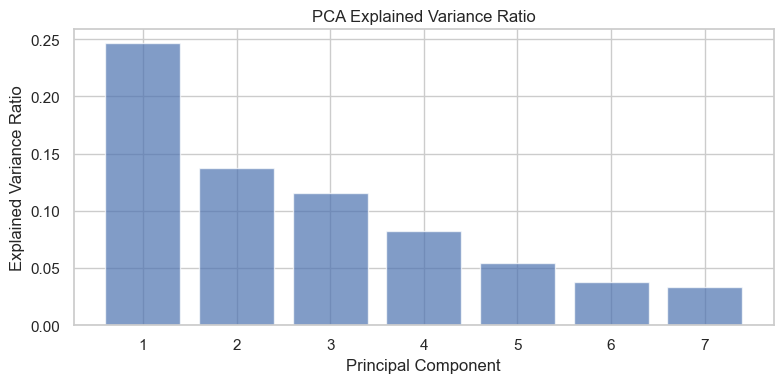

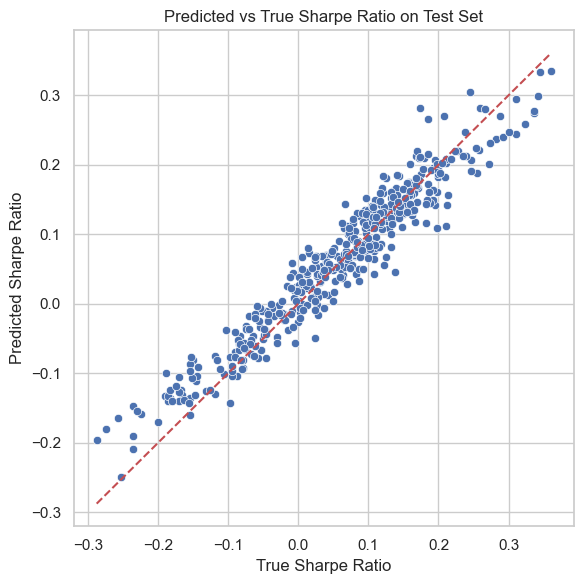

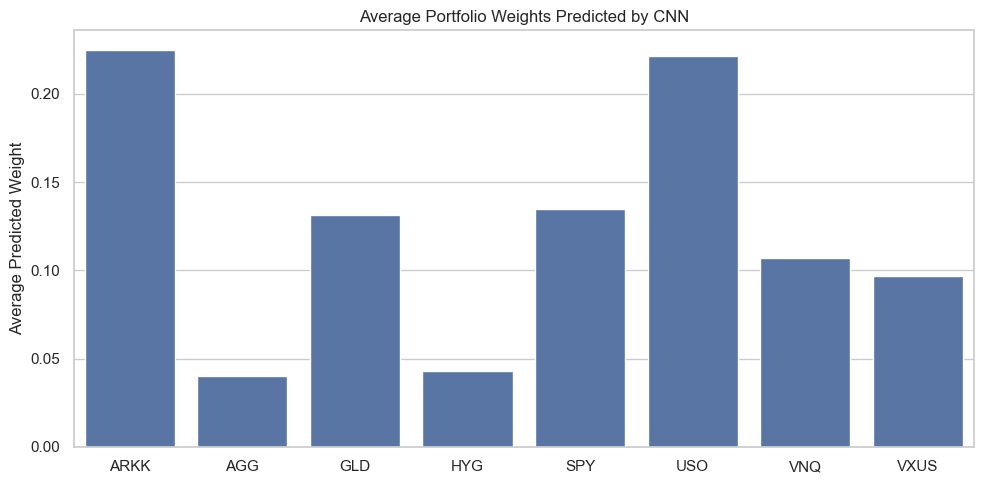

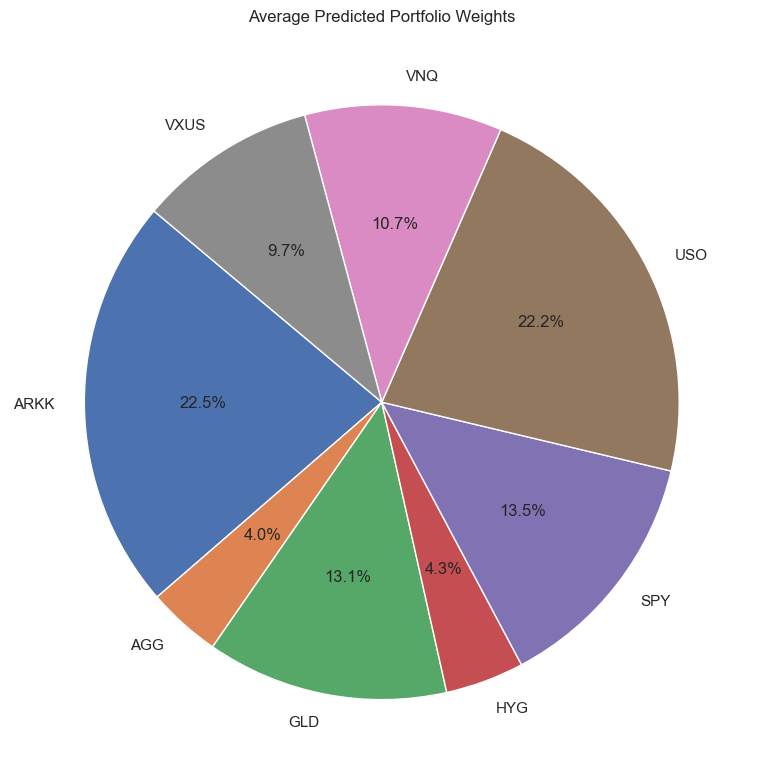

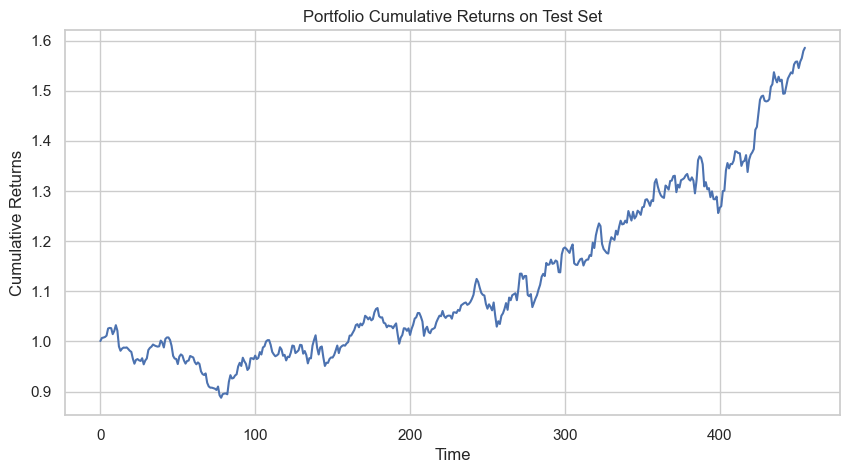

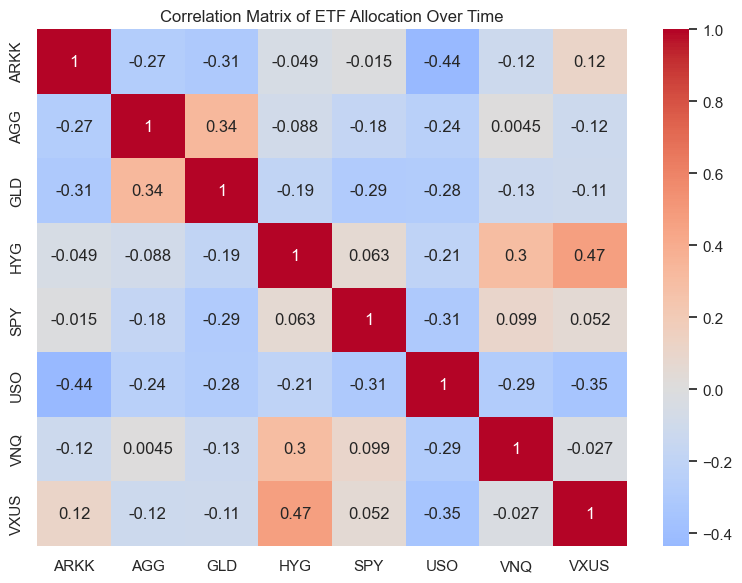

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='whitegrid')

# Ensure dates_test is a pd.DatetimeIndex aligned with test set length
# Example: dates_test = df_wide.index[-len(pred_weights):]

# --- 1. PCA Explained Variance Ratio ---
plt.figure(figsize=(8,4))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_)+1))
plt.tight_layout()
plt.show()

# --- 2. Training Loss over Epochs (if available) ---
if 'history_losses' in globals():
    plt.figure(figsize=(8,4))
    plt.plot(history_losses, marker='o')
    plt.title('Training MSE Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 3. Predicted vs True Sharpe Ratio Scatter ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_sharpe_test, y=pred_sharpe)
min_val = min(min(y_sharpe_test), min(pred_sharpe))
max_val = max(max(y_sharpe_test), max(pred_sharpe))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('Predicted vs True Sharpe Ratio on Test Set')
plt.tight_layout()
plt.show()

# --- 4. Average Predicted Portfolio Weights (Bar Plot) ---
avg_weights = pred_weights.mean(axis=0)
plt.figure(figsize=(10,5))
sns.barplot(x=assets, y=avg_weights)
plt.ylabel('Average Predicted Weight')
plt.title('Average Portfolio Weights Predicted by CNN')
plt.tight_layout()
plt.show()

# --- 5. Pie Chart of Average Predicted Portfolio Weights ---
plt.figure(figsize=(8,8))
plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=140)
plt.title("Average Predicted Portfolio Weights")
plt.tight_layout()
plt.show()

# # --- 6. Test Portfolio Cumulative Returns ---
# portfolio_returns_series = pd.Series(portfolio_returns, index=dates_test)
# cum_returns = (1 + portfolio_returns_series).cumprod()

# plt.figure(figsize=(10,5))
# plt.plot(cum_returns.index, cum_returns.values, label='Test Portfolio')
# plt.title('Test Portfolio Cumulative Returns')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Return')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# 5. Portfolio Cumulative Returns Plot
cum_returns = (1 + portfolio_returns).cumprod()
plt.figure(figsize=(10,5))
plt.plot(cum_returns.index if hasattr(cum_returns, 'index') else range(len(cum_returns)), cum_returns)
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Cumulative Returns on Test Set')
plt.show()

# --- 7. Optional: Training Portfolio Cumulative Returns (if available) ---
if 'train_portfolio_returns' in globals() and 'dates_train' in globals():
    train_returns_series = pd.Series(train_portfolio_returns, index=dates_train)
    train_cum_returns = (1 + train_returns_series).cumprod()
    plt.figure(figsize=(10,5))
    plt.plot(train_cum_returns.index, train_cum_returns.values, label='Training Portfolio')
    plt.plot(cum_returns.index, cum_returns.values, label='Test Portfolio')
    plt.title('Training vs Test Portfolio Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# # --- 8. Portfolio Drawdown Plot ---
# peak = cum_returns.cummax()
# drawdown = (peak - cum_returns) / peak
# plt.figure(figsize=(10,5))
# plt.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
# plt.title('Portfolio Drawdown on Test Set')
# plt.xlabel('Date')
# plt.ylabel('Drawdown')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # --- 9. Portfolio Weights Over Time (Line Plot) ---
# plt.figure(figsize=(12,6))
# for i, asset in enumerate(assets):
#     plt.plot(dates_test, pred_weights[:, i], label=asset)
# plt.title('Portfolio Weights Over Time')
# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # --- 10. Heatmap of ETF Allocation Over Time ---
# plt.figure(figsize=(12,6))
# sns.heatmap(pred_weights.T, xticklabels=dates_test.strftime('%Y-%m-%d'), yticklabels=assets, cmap='viridis')
# plt.title('Heatmap of ETF Allocation Over Time')
# plt.xlabel('Date')
# plt.ylabel('ETF')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


# --- 11. Correlation Matrix of ETF Allocation Over Time ---
corr_matrix = pd.DataFrame(pred_weights, columns=assets).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of ETF Allocation Over Time')
plt.tight_layout()
plt.show()


In [36]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='TB', size='8,12', dpi='300', bgcolor='white')

colors = [
    "#e3f2fd",  # lightest blue
    "#bbdefb",  # lighter blue
    "#90caf9",  # medium blue
    "#42a5f5",  # primary blue
    "#1976d2",  # deep blue
]

dot.node('A', '''Input Layer
[batch, lookback, 8 assets × 20 features]
(e.g. returns, EMA, RSI, etc.)''',
         shape='box', style='rounded,filled', fillcolor=colors[0], fontsize='16')

dot.node('B', '''Standardization
Zero mean, unit variance''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

dot.node('C', '''PCA Transformation
Output: [batch, lookback, k PCA components]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

dot.node('D', '''Unsqueeze
[batch, 1, lookback, k]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

dot.node('E', '''Conv2d Layer
8 filters, kernel=(3,1)
Output: [batch, 8, lookback, k]''',
         shape='box', style='rounded,filled', fillcolor=colors[3], fontsize='16')

dot.node('F', '''ReLU Activation
Non-linearity''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

dot.node('G', '''Flatten Layer
Output: [batch, flattened_size]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

dot.node('H', '''Fully Connected Layer
Linear: [*, 8 assets]''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

dot.node('I', '''Softmax (with Temperature)
Output: Portfolio Weights
[batch, 8 assets] (sum=1)''',
         shape='box', style='rounded,filled', fillcolor='#43a047', fontcolor='white', fontsize='18', fontname='Helvetica')

dot.edge('A', 'B', color='#1976D2', penwidth='2')
dot.edge('B', 'C', color='#1976D2', penwidth='2')
dot.edge('C', 'D', color='#1976D2', penwidth='2')
dot.edge('D', 'E', color='#1976D2', penwidth='2')
dot.edge('E', 'F', color='#1976D2', penwidth='2')
dot.edge('F', 'G', color='#1976D2', penwidth='2')
dot.edge('G', 'H', color='#1976D2', penwidth='2')
dot.edge('H', 'I', color='#43a047', penwidth='2')

dot.render('cnn_pca_portfolio_architecture', view=True)


'cnn_pca_portfolio_architecture.png'

### Risk-Folio Visualizations